In [1]:
pip install albumentations==1.3.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from timm.utils import ModelEmaV2
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

import re
import pydicom

In [3]:
rd='/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
rs='/kaggle/input/spinal-stenosis-training-model'

In [4]:
OUTPUT_DIR = '/kaggle/working/Test_Results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count()
USE_AMP = True
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

N_FOLDS = 5

MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k"

BATCH_SIZE = 1

In [5]:
df = pd.read_csv(f'{rd}/test_series_descriptions.csv')
df.head()

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [6]:
study_ids = list(df['study_id'].unique())
study_ids

[44036939]

In [7]:
sample_sub = pd.read_csv(f'{rd}/sample_submission.csv')

In [8]:
LABELS = list(sample_sub.columns[1:])
LABELS

['normal_mild', 'moderate', 'severe']

In [9]:
CONDITIONS = [
    'spinal_canal_stenosis', 
    'left_neural_foraminal_narrowing', 
    'right_neural_foraminal_narrowing',
    'left_subarticular_stenosis',
    'right_subarticular_stenosis'
]

LEVELS = [
    'l1_l2',
    'l2_l3',
    'l3_l4',
    'l4_l5',
    'l5_s1',
]

In [10]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [11]:
class RSNA24TestDataset(Dataset):
    def __init__(self, df, study_ids, phase='test', transform=None):
        self.df = df
        self.study_ids = study_ids
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.study_ids)
    
    def get_img_paths(self, study_id, series_desc):
        pdf = self.df[self.df['study_id']==study_id]
        pdf_ = pdf[pdf['series_description']==series_desc]
        allimgs = []
        for i, row in pdf_.iterrows():
            pimgs = glob.glob(f'{rd}/test_images/{study_id}/{row["series_id"]}/*.dcm')
            pimgs = sorted(pimgs, key=natural_keys)
            allimgs.extend(pimgs)
            
        return allimgs
    
    def read_dcm_ret_arr(self, src_path):
        dicom_data = pydicom.dcmread(src_path)
        image = dicom_data.pixel_array
        image = (image - image.min()) / (image.max() - image.min() + 1e-6) * 255
        img = cv2.resize(image, (IMG_SIZE[0], IMG_SIZE[1]),interpolation=cv2.INTER_CUBIC)
        assert img.shape==(IMG_SIZE[0], IMG_SIZE[1])
        return img

    def __getitem__(self, idx):
        x = np.zeros((IMG_SIZE[0], IMG_SIZE[1], IN_CHANS), dtype=np.uint8)
        st_id = self.study_ids[idx]        
        
        # Sagittal T1
        allimgs_st1 = self.get_img_paths(st_id, 'Sagittal T1')
        if len(allimgs_st1)==0:
            print(st_id, ': Sagittal T1, has no images')
        
        else:
            step = len(allimgs_st1) / 10.0
            st = len(allimgs_st1)/2.0 - 4.0*step
            end = len(allimgs_st1)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    ind2 = max(0, int((i-0.5001).round()))
                    img = self.read_dcm_ret_arr(allimgs_st1[ind2])
                    x[..., j] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {st_id}, Sagittal T1')
                    pass
            
        # Sagittal T2/STIR
        allimgs_st2 = self.get_img_paths(st_id, 'Sagittal T2/STIR')
        if len(allimgs_st2)==0:
            print(st_id, ': Sagittal T2/STIR, has no images')
            
        else:
            step = len(allimgs_st2) / 10.0
            st = len(allimgs_st2)/2.0 - 4.0*step
            end = len(allimgs_st2)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    ind2 = max(0, int((i-0.5001).round()))
                    img = self.read_dcm_ret_arr(allimgs_st2[ind2])
                    x[..., j+10] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {st_id}, Sagittal T2/STIR')
                    pass
            
        # Axial T2
        allimgs_at2 = self.get_img_paths(st_id, 'Axial T2')
        if len(allimgs_at2)==0:
            print(st_id, ': Axial T2, has no images')
            
        else:
            step = len(allimgs_at2) / 10.0
            st = len(allimgs_at2)/2.0 - 4.0*step
            end = len(allimgs_at2)+0.0001

            for j, i in enumerate(np.arange(st, end, step)):
                try:
                    ind2 = max(0, int((i-0.5001).round()))
                    img = self.read_dcm_ret_arr(allimgs_at2[ind2])
                    x[..., j+20] = img.astype(np.uint8)
                except:
                    print(f'failed to load on {st_id}, Axial T2')
                    pass  
            
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, str(st_id)

In [12]:
transforms_test = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

In [13]:
test_ds = RSNA24TestDataset(df, study_ids, transform=transforms_test)
test_dl = DataLoader(
    test_ds, 
    batch_size=1, 
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=True,
    drop_last=False
)

In [14]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        y = self.model(x)
        return y

In [15]:
models = []

In [16]:
import glob
CKPT_PATHS = glob.glob('/kaggle/input/spinal-stenosis-training-model/Results/best_wll_model_fold-*.pt')
CKPT_PATHS = sorted(CKPT_PATHS)

In [17]:
for i, cp in enumerate(CKPT_PATHS):
    print(f'loading {cp}...')
    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=False)
    model.load_state_dict(torch.load(cp))
    model.eval()
    model.half()
    model.to(device)
    models.append(model)

loading /kaggle/input/spinal-stenosis-training-model/Results/best_wll_model_fold-0.pt...


<ipython-input-17-b29f71628e95>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cp))


loading /kaggle/input/spinal-stenosis-training-model/Results/best_wll_model_fold-1.pt...
loading /kaggle/input/spinal-stenosis-training-model/Results/best_wll_model_fold-2.pt...
loading /kaggle/input/spinal-stenosis-training-model/Results/best_wll_model_fold-3.pt...
loading /kaggle/input/spinal-stenosis-training-model/Results/best_wll_model_fold-4.pt...


In [18]:
autocast = torch.amp.autocast('cuda', dtype=torch.half)
y_preds = []
row_names = []

with tqdm(test_dl, leave=True) as pbar:
    with torch.no_grad():
        for idx, (x, si) in enumerate(pbar):
            x = x.to(device)
            pred_per_study = np.zeros((25, 3))
            
            for cond in CONDITIONS:
                for level in LEVELS:
                    row_names.append(si[0] + '_' + cond + '_' + level)
            
            with autocast:
                for m in models:
                    y = m(x)[0]
                    for col in range(N_LABELS):
                        pred = y[col*3:col*3+3]
                        y_pred = pred.float().softmax(0).cpu().numpy()
                        pred_per_study[col] += y_pred / len(models)
                y_preds.append(pred_per_study)

y_preds = np.concatenate(y_preds, axis=0)

100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


In [19]:
row_names = []

for cond in CONDITIONS:
    for level in LEVELS:
        row_names.append(f"{cond}_{level}")
sub = pd.DataFrame()
sub['row_id'] = row_names
sub[LABELS] = y_preds
sub


,row_id,normal_mild,moderate,severe
0,spinal_canal_stenosis_l1_l2,0.609664,0.254412,0.135924
1,spinal_canal_stenosis_l2_l3,0.372699,0.287563,0.339737
2,spinal_canal_stenosis_l3_l4,0.261529,0.353212,0.385259
3,spinal_canal_stenosis_l4_l5,0.229292,0.183966,0.586742
4,spinal_canal_stenosis_l5_s1,0.830804,0.088939,0.080257
5,left_neural_foraminal_narrowing_l1_l2,0.647185,0.294400,0.058415
6,left_neural_foraminal_narrowing_l2_l3,0.405058,0.460811,0.134131
7,left_neural_foraminal_narrowing_l3_l4,0.268485,0.563102,0.168413
8,left_neural_foraminal_narrowing_l4_l5,0.169393,0.442882,0.387724
9,left_neural_foraminal_narrowing_l5_s1,0.204646,0.412090,0.383264


In [20]:
sub.to_csv("/kaggle/working/submission.csv", index=False)
print("CSV file saved as submission.csv")

CSV file saved as submission.csv


In [21]:

file_path = "submission.csv"
df = pd.read_csv(file_path)


feature1 = "normal_mild"
feature2 = "moderate"
feature3 = "severe"

feature_higher_df = df[(df[feature3] > df[feature1]) & (df[feature3] > df[feature2])]

print("\nRows where 'severe' is higher than other two features:\n", feature_higher_df)

feature_higher_df.to_csv("severe_higher.csv", index=False)
print("\nFiltered results saved to 'severe_higher.csv'")



Rows where 'severe' is higher than other two features:
                                     row_id  normal_mild  moderate    severe
2              spinal_canal_stenosis_l3_l4     0.261529  0.353212  0.385259
3              spinal_canal_stenosis_l4_l5     0.229292  0.183966  0.586742
13  right_neural_foraminal_narrowing_l4_l5     0.139044  0.415760  0.445196
14  right_neural_foraminal_narrowing_l5_s1     0.266315  0.259217  0.474469
18        left_subarticular_stenosis_l4_l5     0.094756  0.277670  0.627574
22       right_subarticular_stenosis_l3_l4     0.181466  0.306328  0.512206
23       right_subarticular_stenosis_l4_l5     0.101700  0.302084  0.596216
24       right_subarticular_stenosis_l5_s1     0.345011  0.303739  0.351250

Filtered results saved to 'severe_higher.csv'


Loaded 8 conditions from CSV
Found 8 matches between images and conditions
Unmatched conditions: 0
Unmatched images: 17


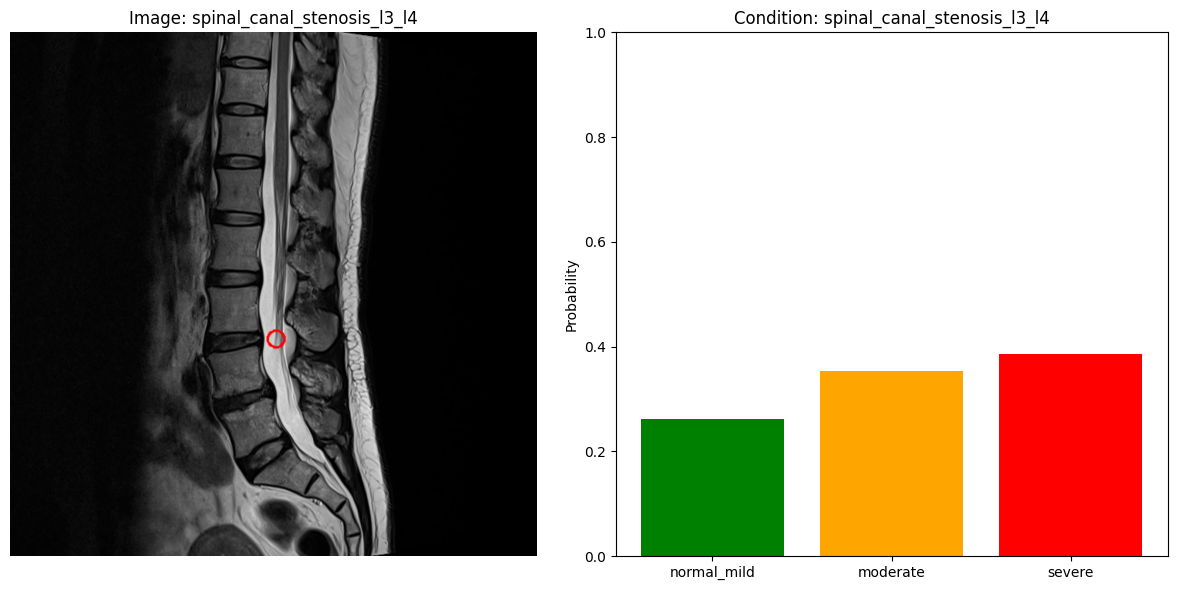

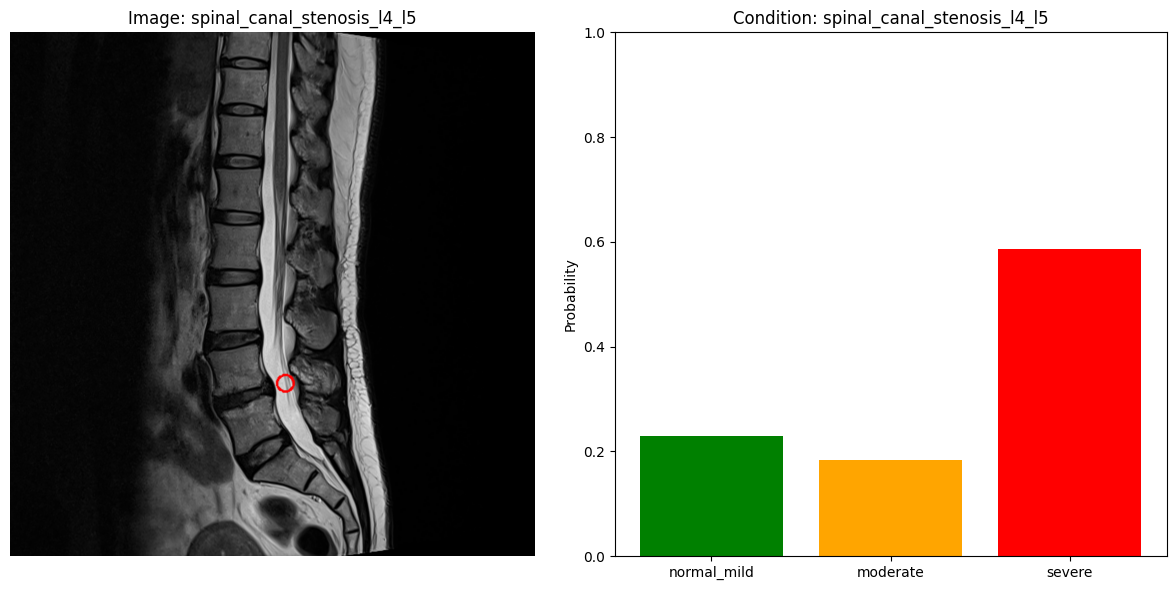

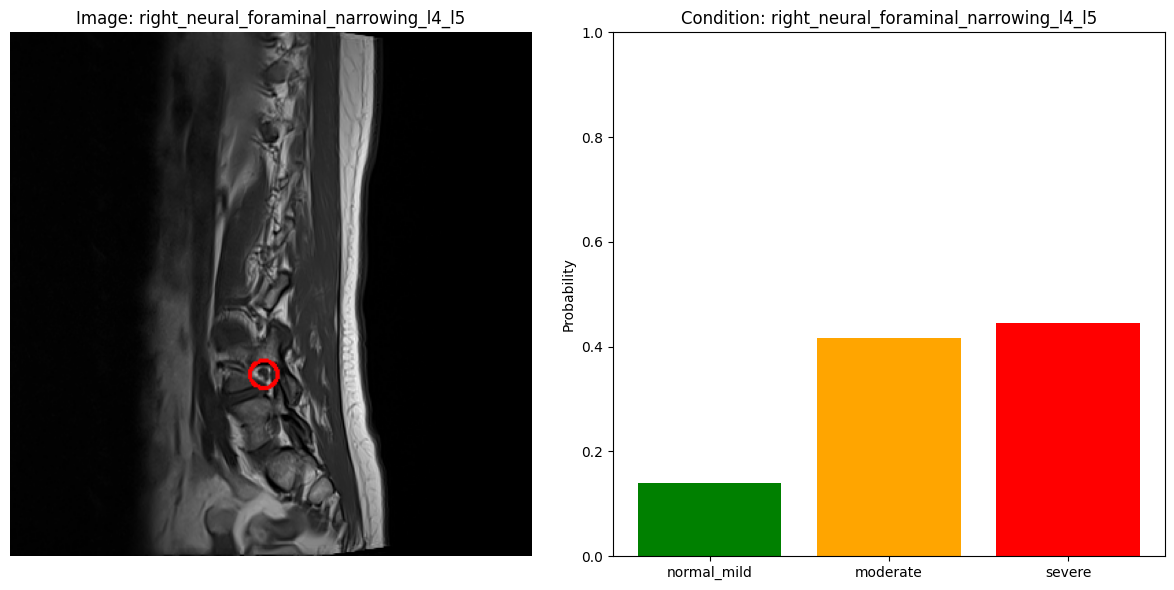

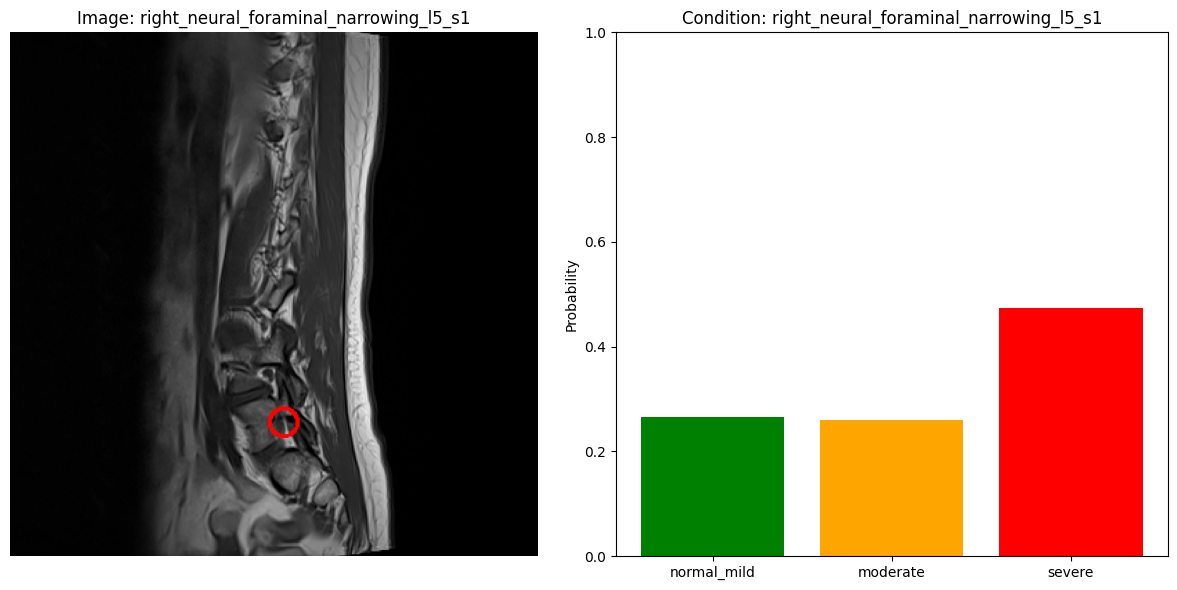

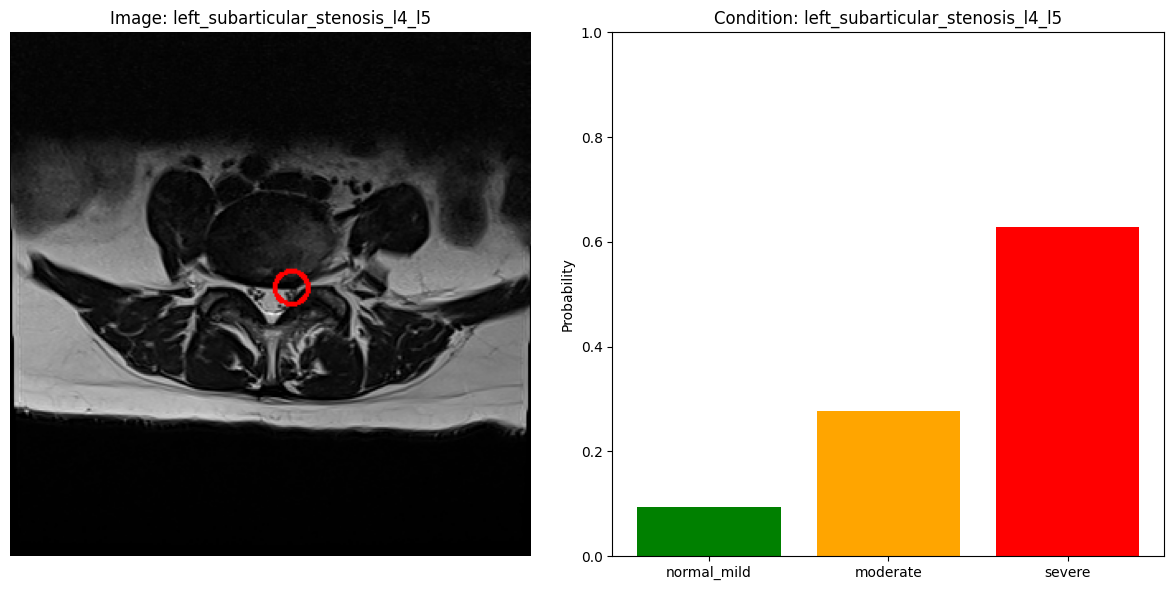

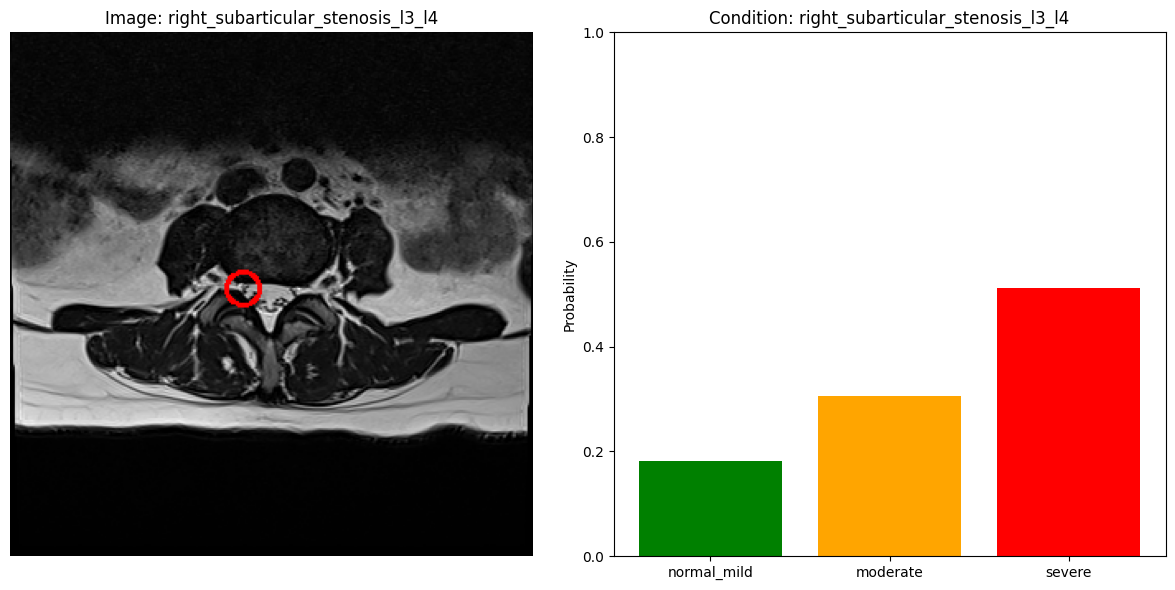

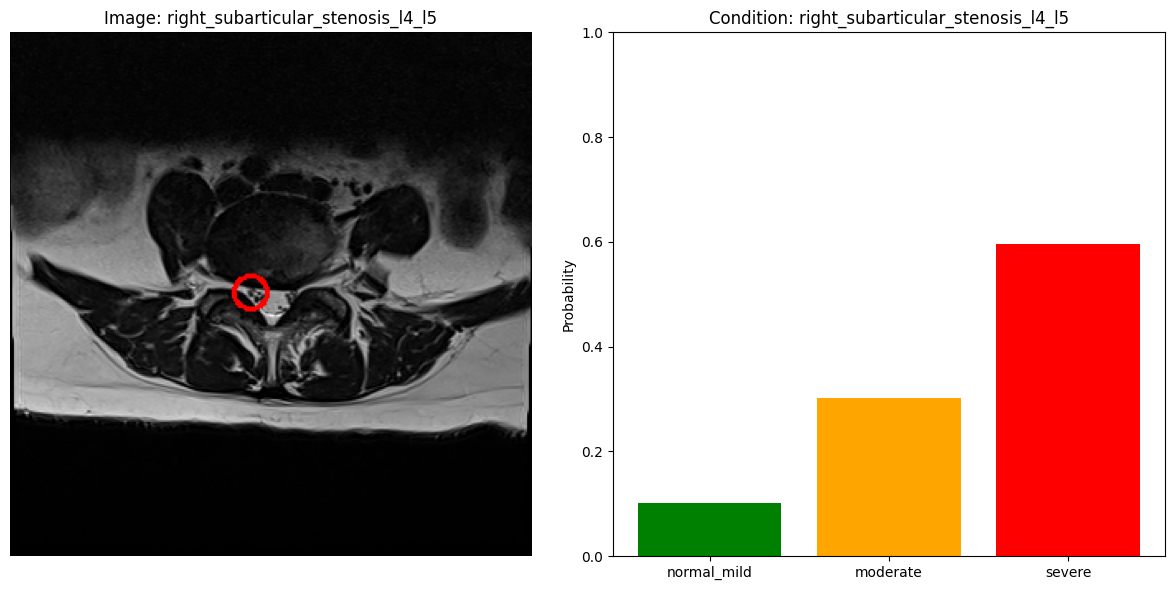

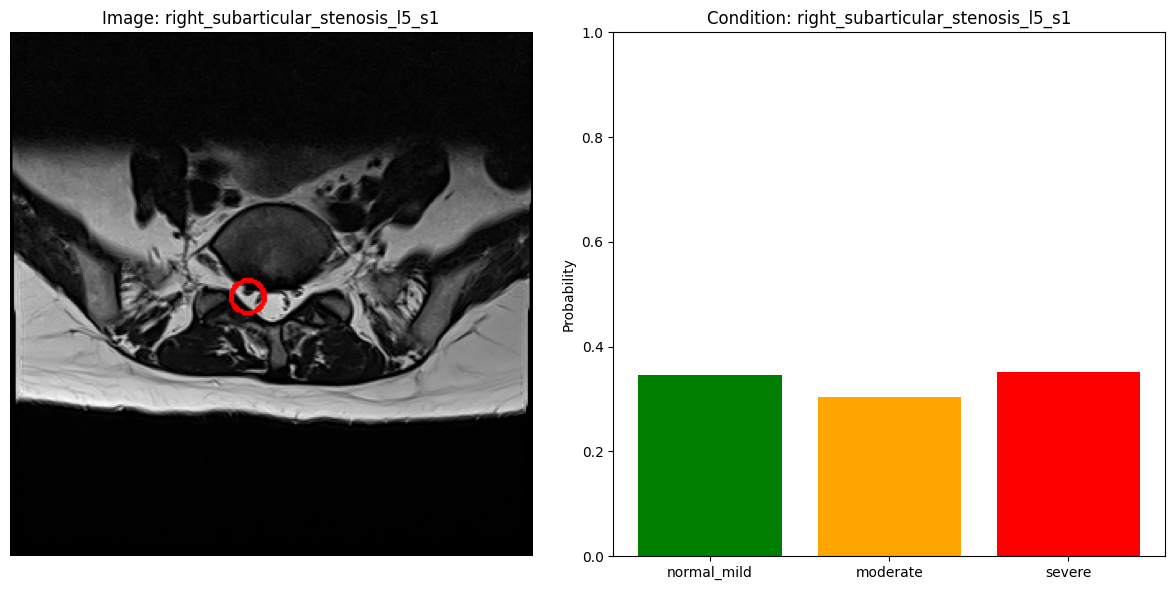

In [22]:
def match_images_with_csv(csv_path, image_dir):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Get all image files from the directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # Create a dictionary to store matches
    matches = {}
    unmatched_rows = []
    unmatched_images = []

    # Extract condition names from row_ids
    conditions = df['row_id'].tolist()

    # Try to match images with conditions
    for condition in conditions:
        found_match = False
        for img_file in image_files:
            # Simple matching strategy: check if condition name appears in the filename
            if condition.lower() in img_file.lower():
                matches[condition] = img_file
                found_match = True
                break

        if not found_match:
            unmatched_rows.append(condition)

    # Find unmatched images
    matched_images = list(matches.values())
    unmatched_images = [img for img in image_files if img not in matched_images]

    return matches, unmatched_rows, unmatched_images

def visualize_match(image_path, condition_data):
    """
    Display the image with its probability data using row_id from CSV as the title
    """
    img = plt.imread(image_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Display image with row_id as title instead of image filename
    ax1.imshow(img, cmap='gray')
    ax1.set_title(f"Image: {condition_data.name}")
    ax1.axis('off')

    # Display probability bars
    categories = ['normal_mild', 'moderate', 'severe']
    values = [condition_data[cat] for cat in categories]

    ax2.bar(categories, values, color=['green', 'orange', 'red'])
    ax2.set_ylim(0, 1)
    ax2.set_title(f"Condition: {condition_data.name}")
    ax2.set_ylabel('Probability')

    plt.tight_layout()
    plt.show()

# Load the CSV with row_id as index
csv_path = "/kaggle/working/severe_higher.csv"
image_dir = f"/kaggle/input/images/images/pathology/"
image_path = os.path.join(image_dir, f"{idx}.png")
df = pd.read_csv(csv_path, index_col='row_id')
print(f"Loaded {len(df)} conditions from CSV")

# Get the matching between images and conditions
matches, unmatched_rows, unmatched_images = match_images_with_csv(csv_path, image_dir)

print(f"Found {len(matches)} matches between images and conditions")
print(f"Unmatched conditions: {len(unmatched_rows)}")
print(f"Unmatched images: {len(unmatched_images)}")

# Visualize matches
for idx, row in df.iterrows():
    image_path = f"{image_dir}/{idx}.png"  # Adjust as necessary
    visualize_match(image_path, row)
